## Agent 1

### 1.1. Introduction to the Problem

#### Reinforcement Learning for Pattern Recognition in Event Streams

This project implements a reinforcement learning solution to the "Open the Chests" environment, which represents a pattern recognition challenge in event-driven decision-making. In this environment, an agent must learn to recognize specific event sequences and take appropriate actions based on those patterns.

The core challenge is teaching an agent to:
1. Process and understand sequential events
2. Identify meaningful patterns in these events  
3. Make appropriate decisions based on recognized patterns
4. Balance between exploration (trying new actions) and exploitation (using known effective actions)

We'll explore different approaches to this problem, scaling from simple to complex solutions based on the environment difficulty.

### 1.2. Understanding the Environment: "Open the Chests"

#### The "Open the Chests" Environment

The **Open the Chests** environment introduces **event-driven decision-making**, where the robot must **recognize patterns in an event stream** and take the appropriate action. The environment simulates a scenario where **various activities generate a stream of events**, each representing a **significant observation**.

The robot's goal is to:
- **Recognize event signatures** in the stream.
- **Associate events with specific activities**.
- **Use this information to open the correct chest** by taking the appropriate action.

This requires the robot to **learn how to interpret event sequences** and **respond accordingly**.

### Environment Variants

There are three configurations of increasing difficulty:

1. **Easy (v0)**: Each chest is associated with a single event
   - Simple one-to-one mapping between event and action
   - No temporal dependency
   - Solvable using basic RL approaches

2. **Medium (v1)**: Each chest is associated with a sequence of 4 events
   - Requires tracking short event sequences
   - Introduces temporal dependencies
   - Needs memory mechanisms to track sequences

3. **Hard (v2)**: Each chest is associated with a complex sequence of 16 events
   - Requires tracking long-term dependencies
   - Needs advanced pattern recognition
   - Requires sophisticated memory mechanisms

These variants allow us to test different algorithmic approaches and architecture choices for reinforcement learning in sequential decision-making tasks.

### 1.3. Algorithms and Approach

#### Deep Reinforcement Learning Approach

To solve the "Open the Chests" environment, we employ **Deep Q-Learning (DQN)** with several advanced modifications based on the complexity of each environment variant.

#### Core Algorithm: Deep Q-Learning

Deep Q-Learning combines Q-Learning with deep neural networks to approximate the action-value function. The key components include:

1. **Experience Replay**: Stores experiences (state, action, reward, next_state) in a buffer and samples randomly to break correlations between consecutive samples
2. **Target Network**: A separate network that provides stable targets for the learning network
3. **Epsilon-Greedy Exploration**: Balances exploration and exploitation by selecting random actions with probability ε

#### Advanced Techniques (for more complex variants)

As the environment complexity increases, we incorporate additional techniques:

- **Long Short-Term Memory (LSTM)**: For v1 and v2, to capture temporal dependencies in event sequences
- **Transformer Layers**: For v2, to better model complex long-range dependencies
- **Double DQN**: Reduces overestimation bias in action values
- **Prioritized Experience Replay**: Samples more important transitions more frequently
- **Gradient Clipping**: Prevents exploding gradients during training
- **Soft Target Updates**: Gradually updates target network for more stable learning

Each environment variant uses an architecture tailored to its specific challenges.

### 1.4. Network Architecture

#### Model Architecture

Our implementation uses three different neural network architectures, each designed for a specific environment complexity level:

#### Simple MLP (v0)
For the simplest environment with one-to-one event-to-chest mapping, we use a Multi-Layer Perceptron:
- Input layer based on environment observation size
- Two hidden layers with ReLU activation and dropout
- Output layer with one node per action

#### LSTM Network (v1)
For the medium complexity environment with short sequences, we use a recurrent architecture:
- Embedding layer to process input features
- LSTM layer to maintain temporal context
- Layer normalization for training stability
- Fully connected output layers

#### LSTM + Transformer Architecture (v2)
For the complex environment with long sequences, we use a sophisticated architecture:
- Embedding layer with batch normalization
- LSTM layer for sequence processing
- Transformer encoder with self-attention
- Advanced pooling mechanism using attention weights
- Regularized output layers with strong dropout

Each architecture is specifically tuned to handle the temporal complexity requirements of its target environment.

#### 1.5. Network Architecture Code

In [9]:
# Imports
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import warnings
import os
import traceback

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Ignore gym warnings
warnings.filterwarnings("ignore", category=UserWarning, module='gym')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='gym')
warnings.filterwarnings("ignore", category=FutureWarning, module='gym')

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [ ]:
class DQNModel(nn.Module):
    def __init__(self, input_size, output_size, env_version=0):
        super(DQNModel, self).__init__()
        self.env_version = env_version
        self.lstm_hidden = None
        
        if env_version == 0:  # Simple MLP for v0
            self.hidden_size = 128
            self.network = nn.Sequential(
                nn.Linear(input_size, self.hidden_size),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, output_size)
            )
            
        elif env_version == 1:  # LSTM for v1
            self.hidden_size = 96
            self.embedding = nn.Linear(input_size, 64)
            self.lstm = nn.LSTM(64, self.hidden_size, batch_first=True)
            self.fc = nn.Sequential(
                nn.Linear(self.hidden_size, 64),
                nn.ReLU(),
                nn.Linear(64, output_size)
            )
            
        else:  # v2 
            self.hidden_size = 128
            self.embedding = nn.Linear(input_size, self.hidden_size)
            self.emb_norm = nn.BatchNorm1d(self.hidden_size)
            self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=1, batch_first=True)
            self.norm1 = nn.LayerNorm(self.hidden_size)
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=self.hidden_size, 
                nhead=4, 
                dim_feedforward=128,  
                dropout=0.3,         
                batch_first=True
            )
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
            self.norm2 = nn.LayerNorm(self.hidden_size)
            self.fc = nn.Sequential(
                nn.Linear(self.hidden_size, 64),  
                nn.ReLU(),
                nn.Dropout(0.3),     
                nn.Linear(64, output_size)
            )
            
            self._init_weights()

    def _init_weights(self):
        if self.env_version == 2:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.orthogonal_(m.weight, gain=1.0)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0.0)

    def reset_hidden(self, batch_size=1):
        if self.env_version > 0:
            try:
                device = next(self.parameters()).device
                if self.env_version == 1:
                    num_layers = 1
                    hidden_size = self.hidden_size
                else:  # v2
                    num_layers = 1
                    hidden_size = self.hidden_size
                
                self.lstm_hidden = (
                    torch.zeros(num_layers, batch_size, hidden_size, device=device),
                    torch.zeros(num_layers, batch_size, hidden_size, device=device)
                )
            except (StopIteration, AttributeError):
                pass

    def detach_hidden(self):
        if self.env_version > 0 and self.lstm_hidden is not None:
            self.lstm_hidden = (self.lstm_hidden[0].detach(), self.lstm_hidden[1].detach())

    def forward(self, x):
        if self.env_version == 0:
            return self.network(x)

        elif self.env_version == 1:
            batch_size = x.size(0)
            if self.lstm_hidden is None or self.lstm_hidden[0].size(1) != batch_size:
                self.reset_hidden(batch_size)

            x = F.relu(self.embedding(x))
            lstm_out, self.lstm_hidden = self.lstm(x, self.lstm_hidden)
            x = lstm_out[:, -1, :]  
            return self.fc(x)

        else:  # v2 with transformer
            batch_size = x.size(0)
            seq_len = x.size(1)
            
            if self.lstm_hidden is None or self.lstm_hidden[0].size(1) != batch_size:
                self.reset_hidden(batch_size)
            
            x = F.relu(self.embedding(x))
            
            orig_shape = x.shape
            x = x.reshape(-1, self.hidden_size)
            x = self.emb_norm(x)
            x = x.reshape(orig_shape)
            
            x = F.dropout(x, p=0.15, training=self.training)
            
            lstm_out, self.lstm_hidden = self.lstm(x, self.lstm_hidden)
            x = self.norm1(lstm_out)
            
            x = self.transformer(x)
            x = self.norm2(x)
            
            attn_weights = F.softmax(torch.matmul(x, x[:, -1, :].unsqueeze(2)), dim=1)
            x = torch.sum(x * attn_weights, dim=1)
            
            return self.fc(x)


### 1.6. Agent Implementation

#### The OpenTheChestsAgent Class

The `OpenTheChestsAgent` class is responsible for:

1. **Environment Interaction**: Communicates with the "Open the Chests" environment
2. **Experience Management**: Stores and samples transitions from experience replay buffer
3. **Action Selection**: Implements epsilon-greedy policy for exploration/exploitation
4. **Learning**: Updates the policy network based on experiences
5. **Evaluation**: Tests agent performance on unseen episodes

The agent is designed to handle all three environment variants (v0, v1, v2) with appropriate hyperparameters and model architectures for each.

### Key Features:

- **Version-specific Hyperparameters**: Each environment version uses optimized learning settings
- **Sequence Memory**: For v1 and v2, maintains a memory of recent observations
- **Training Stability**: Includes safeguards against training instability like gradient clipping
- **Adaptive Learning Rate**: Adjusts learning rate during training for v2
- **Model Persistence**: Saves and loads agent state for continued training
- **Performance Tracking**: Records training progress for analysis and visualization

In [10]:
class ReplayMemory:
    """
    A replay buffer for storing and sampling experiences in reinforcement learning.
    
    This class implements a fixed-size memory that stores transitions (state, action, 
    next_state, reward) and allows random sampling of stored experiences for training.
    When capacity is reached, oldest experiences are automatically discarded.
    
    """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        actual_batch_size = min(batch_size, len(self.memory))
        if actual_batch_size == 0:
            return []
        return random.sample(self.memory, actual_batch_size)

    def __len__(self):
        return len(self.memory)

### 1.7. Prioritized Experience Replay memory for more efficient reinforcement learning.

In [ ]:

class PrioritizedReplayMemory:
    """
    Prioritized Experience Replay memory for more efficient reinforcement learning.
    
    This class implements a fixed-size memory with prioritized sampling, which
    gives higher probability to experiences with higher temporal-difference (TD)
    errors. This approach focuses training on the most informative transitions,
    leading to faster and more stable learning compared to uniform sampling.
    
    Parameters:
    -----------
    capacity : int
        Maximum number of transitions to store in the buffer.
    alpha : float, default=0.6
        Determines how much prioritization is used. 
        α = 0 corresponds to uniform sampling, while α = 1 corresponds to 
        sampling strictly according to priorities.
    beta : float, default=0.4
        Controls the extent of importance sampling weight correction.
        β = 1 fully compensates for the non-uniform sampling.
        This value is gradually increased to 1 during training.
    beta_increment : float, default=0.001
        The amount to increase beta after each sampling operation,
        gradually moving from biased sampling to compensated sampling.
    
    """
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent
        self.beta = beta    # Importance sampling correction
        self.beta_increment = beta_increment  # Gradually increase beta to 1
        self.memory = []
        self.priorities = np.ones((capacity,), dtype=np.float32)
        self.position = 0
        self.max_priority = 1.0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.priorities[self.position] = self.max_priority
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) == 0:
            return []
        
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        priorities = self.priorities[:len(self.memory)]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.memory), min(batch_size, len(self.memory)), 
                                  replace=False, p=probs)
        
        weights = (len(self.memory) * probs[indices]) ** (-self.beta)
        weights /= weights.max() 
        samples = [self.memory[idx] for idx in indices]
        return samples, indices, torch.tensor(weights, dtype=torch.float32)

    def update_priorities(self, indices, td_errors):
        for idx, error in zip(indices, td_errors):
            priority = abs(error) + 1e-5 
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return len(self.memory)

### 1.8. Agent Code - Core Methods

In [12]:

class OpenTheChestsAgent:
    """
    A reinforcement learning agent designed to solve the OpenTheChests environments
    of varying complexity using different neural network architectures.
    
    This agent implements Deep Q-Network (DQN) variants with environment-specific
    architectures: MLP for simple environments (v0), LSTM for medium complexity (v1),
    and LSTM+Transformer for complex environments (v2). The agent supports various
    advanced reinforcement learning techniques including:
    
    - Experience replay (standard and prioritized)
    - Target networks with soft updates
    - Double DQN (for complex environments)
    - Epsilon-greedy exploration with decay
    - Gradient clipping for stability
    - Learning rate scheduling
    - Automatic model reset when learning diverges
    - LSTM hidden state management for sequential environments
    
    Each environment version uses tailored hyperparameters and architecture:
    - v0: Simple MLP network for direct state-action mapping
    - v1: LSTM-based network for short sequential patterns
    - v2: Advanced LSTM+Transformer network with additional stability techniques
         for long sequential dependencies
         
    The agent automatically adapts to the environment version, handles observation
    preprocessing, manages model training, evaluation, saving/loading, and provides
    performance visualization tools.
    """
    def __init__(self, env_name, device=None):
        if device:
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        try:
            self.env = gym.make(env_name)
        except gym.error.Error as e:
            print(f"FATAL: Could not create environment {env_name}. Error: {e}")
            raise

        self.env_name = env_name

        if 'v0' in env_name:
            self.version = 0
            self.sequence_length = 1
        elif 'v1' in env_name:
            self.version = 1
            self.sequence_length = 8 
        else:  # v2
            self.version = 2
            self.sequence_length = 10 

        if self.version == 0:
            self.BATCH_SIZE = 64
            self.GAMMA = 0.98
            self.EPS_START = 0.95
            self.EPS_END = 0.05
            self.EPS_DECAY = 800
            self.TAU = 0.01
            self.LR = 3e-4
            self.MEMORY_SIZE = 20000
            self.TARGET_UPDATE_FREQ = 5
            self.LEARNING_STARTS = 500
            self.USE_PRIORITIZED_REPLAY = False
        elif self.version == 1:
            self.BATCH_SIZE = 64
            self.GAMMA = 0.99
            self.EPS_START = 0.9
            self.EPS_END = 0.05
            self.EPS_DECAY = 1000
            self.TAU = 0.01
            self.LR = 1e-4
            self.MEMORY_SIZE = 30000
            self.TARGET_UPDATE_FREQ = 10
            self.LEARNING_STARTS = 500
            self.LSTM_HIDDEN_RESET_FREQ = 6
            self.WEIGHT_DECAY = 1e-5
            self.USE_PRIORITIZED_REPLAY = False
        else:  # v2 
            self.BATCH_SIZE = 32
            self.GAMMA = 0.99
            self.EPS_START = 1.0
            self.EPS_END = 0.05
            self.EPS_DECAY = 3000  # Slower epsilon decay for better exploration
            self.TAU = 0.001  # Lower TAU for slower target updates
            self.LR = 5e-5   # Lower learning rate
            self.MEMORY_SIZE = 40000
            self.TARGET_UPDATE_FREQ = 10
            self.LEARNING_STARTS = 1000
            self.LSTM_HIDDEN_RESET_FREQ = 5 
            self.WEIGHT_DECAY = 1e-4 
            self.USE_PRIORITIZED_REPLAY = True 
            self.USE_DOUBLE_DQN = True  
            self.ACTION_THRESHOLD = 0.4  
            self.GRADIENT_CLIP = 1.0  
            self.DROPOUT_RATE = 0.3 

        try:
            temp_obs = self.env.reset()
        except Exception as e:
            print(f"FATAL: Error resetting environment '{env_name}' during init: {e}")
            raise

        if isinstance(temp_obs, dict):
            self.obs_keys = list(temp_obs.keys())
            flat_obs = self._flatten_observation(temp_obs)
        else:
            self.obs_keys = None
            try:
                flat_obs = temp_obs.flatten()
            except AttributeError:
                flat_obs = np.array([temp_obs])
        input_size = len(flat_obs)

        try:
            self.n_actions = self.env.action_space.n
        except AttributeError:
            print(f"FATAL: Environment {env_name} does not have a discrete action space 'n'.")
            raise

        if self.version > 0:
            self.state_memory = deque(maxlen=self.sequence_length)

        self.policy_net = DQNModel(input_size, self.n_actions, self.version).to(self.device)
        self.target_net = DQNModel(input_size, self.n_actions, self.version).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        wd = getattr(self, 'WEIGHT_DECAY', 0.0)
        if self.version >= 1:
            self.optimizer = optim.AdamW(
                self.policy_net.parameters(), 
                lr=self.LR, 
                weight_decay=wd,
                amsgrad=True
            )
            if self.version == 2:
                self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                    self.optimizer, 
                    T_max=2000, 
                    eta_min=self.LR/10
                )
        else:
            self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)

        if self.USE_PRIORITIZED_REPLAY:
            self.memory = PrioritizedReplayMemory(self.MEMORY_SIZE)
        else:
            self.memory = ReplayMemory(self.MEMORY_SIZE)
            
        self.steps_done = 0
        self.training_rewards = []
        self.eval_rewards = []
        self.losses = []
        self.episodes_since_reset = 0
        self.no_action_counts = []

    def _flatten_observation(self, obs):
        if not isinstance(obs, dict):
            try:
                return obs.flatten().astype(np.float32)
            except AttributeError:
                return np.array([obs], dtype=np.float32)

        flat_obs = []
        if not hasattr(self, 'obs_keys') or self.obs_keys is None:
            self.obs_keys = list(obs.keys())

        for key in self.obs_keys:
            val = obs.get(key)
            if val is None:
                flat_obs.append(0.0)
                continue
            if isinstance(val, np.ndarray):
                flat_obs.extend(val.flatten())
            elif np.isscalar(val):
                flat_obs.append(val)
            else:
                try:
                    flat_obs.append(float(val))
                except (TypeError, ValueError):
                    flat_obs.append(0.0)
        return np.array(flat_obs, dtype=np.float32)

    def preprocess_state(self, state):
        flat_state = self._flatten_observation(state)

        try:
            if self.version == 0:
                input_dim = self.policy_net.network[0].in_features
            else:
                input_dim = self.policy_net.embedding.in_features
        except (AttributeError, IndexError):
            return None

        if flat_state.shape[0] != input_dim:
            return None

        if self.version == 0:
            return torch.tensor(flat_state, dtype=torch.float32, device=self.device).unsqueeze(0)
        else:
            self.state_memory.append(flat_state)
            
            if len(self.state_memory) < self.sequence_length:
                padding = [np.zeros_like(flat_state)] * (self.sequence_length - len(self.state_memory))
                sequence = padding + list(self.state_memory)
            else:
                sequence = list(self.state_memory)

            sequence_np = np.array(sequence, dtype=np.float32)
            return torch.tensor(sequence_np, dtype=torch.float32, device=self.device).unsqueeze(0)

    def select_action(self, state_tensor, evaluate=False):
        if state_tensor is None:
            return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)

        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)

        # Increment step counter except in evaluation
        if not evaluate:
            self.steps_done += 1

        # Use epsilon-greedy policy
        if evaluate or random.random() > eps_threshold:
            self.policy_net.eval()
            with torch.no_grad():
                action_values = self.policy_net(state_tensor)
                
                if self.version == 2 and not evaluate:
                    action_max_value = action_values.max().item()
                    do_nothing_value = action_values[0, 0].item()
                    
                    if do_nothing_value > action_max_value - self.ACTION_THRESHOLD:
                        action = torch.tensor([[0]], device=self.device, dtype=torch.long)
                    else:
                        action = action_values.max(1)[1].view(1, 1)
                else:
                    action = action_values.max(1)[1].view(1, 1)
                    
            if not evaluate:
                self.policy_net.train()
            return action
        else:
            if self.version == 2 and random.random() < 0.3:
                return torch.tensor([[0]], device=self.device, dtype=torch.long)
            else:
                return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE or self.steps_done < self.LEARNING_STARTS:
            return 0.0

        self.policy_net.train()
        self.target_net.eval()

        if self.USE_PRIORITIZED_REPLAY:
            transitions, indices, weights = self.memory.sample(self.BATCH_SIZE)
            weights = weights.to(self.device)
            if not transitions:
                return 0.0
        else:
            transitions = self.memory.sample(self.BATCH_SIZE)
            if not transitions:
                return 0.0
            
        batch = Transition(*zip(*transitions))

        # Filter valid states
        valid_indices = [i for i, s in enumerate(batch.state) if s is not None]
        if len(valid_indices) < self.BATCH_SIZE // 4:
            return 0.0

        state_batch_list = [batch.state[i] for i in valid_indices]
        action_batch_list = [batch.action[i] for i in valid_indices]
        reward_batch_list = [batch.reward[i] for i in valid_indices]
        next_state_batch_list = [batch.next_state[i] for i in valid_indices]

        state_batch = torch.cat(state_batch_list)
        action_batch = torch.cat(action_batch_list)
        reward_batch = torch.cat(reward_batch_list)

        current_batch_size = state_batch.size(0)

        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, next_state_batch_list)), 
            device=self.device, dtype=torch.bool
        )
        non_final_next_states_list = [s for s in next_state_batch_list if s is not None]

        # Concatenate non-final next states
        if len(non_final_next_states_list) > 0:
            non_final_next_states = torch.cat(non_final_next_states_list)
        else:
            non_final_next_states = None
        if self.version > 0:
            self.policy_net.reset_hidden(current_batch_size)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(current_batch_size, device=self.device)
        
        if non_final_next_states is not None:
            if self.version > 0:
                self.target_net.reset_hidden(non_final_next_states.size(0))
                
            with torch.no_grad():
                if self.version == 2 and self.USE_DOUBLE_DQN:
                    if self.version > 0:
                        self.policy_net.reset_hidden(non_final_next_states.size(0))
                    next_action = self.policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
                    next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, next_action).squeeze(1)
                else:
                    next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        # Calculate target Q-values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        if self.version < 2:
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        else:
            if self.USE_PRIORITIZED_REPLAY:
                td_errors = state_action_values.squeeze() - expected_state_action_values
                loss = (td_errors.pow(2) * weights).mean()
                
                self.memory.update_priorities(
                    indices, 
                    td_errors.abs().detach().cpu().numpy()
                )
            else:
                criterion = nn.MSELoss()
                loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.version == 2 and len(valid_indices) > 1:
            action_indices = [a.item() for a in action_batch]
            non_zero_actions = sum([1 for a in action_indices if a > 0])
            action_ratio = non_zero_actions / len(action_indices)
            
            if action_ratio > 0.85:
                loss += 0.02 * action_ratio  
            elif action_ratio < 0.05 and self.steps_done > 10000:
                loss += 0.02 * (1 - action_ratio) 
        
        # Optimization
        self.optimizer.zero_grad()
        loss.backward()
        
        if self.version == 2:
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), self.GRADIENT_CLIP)
        else:
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
            
        self.optimizer.step()

        if self.steps_done % self.TARGET_UPDATE_FREQ == 0:
            self._soft_update_target()

        return loss.item()

    def _soft_update_target(self):
        """Soft update of target network parameters."""
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
        self.target_net.load_state_dict(target_net_state_dict)

    def _reset_networks_if_needed(self):
        """Reset networks if loss is diverging."""
        if self.version == 2 and len(self.losses) > 100:
            recent_avg_loss = np.mean(self.losses[-20:])
            prev_avg_loss = np.mean(self.losses[-40:-20]) if len(self.losses) >= 40 else recent_avg_loss
            
            if recent_avg_loss > 2.0 * prev_avg_loss and recent_avg_loss > 8.0:
                print(f"\nRESETTING NETWORKS: Loss increasing significantly (recent: {recent_avg_loss:.4f}, previous: {prev_avg_loss:.4f})")
                
                try:
                    torch.save({
                        'policy_net': self.policy_net.state_dict(),
                        'target_net': self.target_net.state_dict(),
                        'optimizer': self.optimizer.state_dict(),
                    }, f"pre_reset_backup_{self.env_name}.pth")
                except Exception:
                    pass
                
                # Recreate networks
                input_size = self.policy_net.embedding.in_features
                
                self.policy_net = DQNModel(input_size, self.n_actions, self.version).to(self.device)
                self.target_net = DQNModel(input_size, self.n_actions, self.version).to(self.device)
                self.target_net.load_state_dict(self.policy_net.state_dict())
                self.target_net.eval()
                
                self.optimizer = optim.AdamW(
                    self.policy_net.parameters(), 
                    lr=self.LR * 0.5, 
                    weight_decay=self.WEIGHT_DECAY,
                    amsgrad=True
                )
                
                if hasattr(self, 'scheduler'):
                    self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                        self.optimizer, 
                        T_max=2000, 
                        eta_min=self.LR/10
                    )
                
                self.episodes_since_reset = 0
                return True
                
        return False

    def train_agent(self, num_episodes=1000, max_steps_per_episode=1000, eval_interval=50, eval_episodes=10):
        """Main training loop for the agent."""
        print(f"Starting training for {self.env_name} on {self.device}...")
        best_eval_reward = float('-inf')
        episode_rewards = []
        episode_losses = []
        eval_interval = max(1, eval_interval)
        reset_occurred = False
        no_action_counts = []  

        for episode in range(num_episodes):
            if self.version == 2 and episode > 50 and episode % 50 == 0:
                reset_occurred = self._reset_networks_if_needed()
                
            try:
                raw_state = self.env.reset()
            except Exception as e:
                print(f"Error resetting environment at start of episode {episode}: {e}")
                continue

            current_total_reward = 0
            steps_in_episode = 0
            losses_this_episode = []
            no_action_count = 0  

            if self.version > 0:
                self.state_memory.clear()
                self.policy_net.reset_hidden(batch_size=1)
                self.target_net.reset_hidden(batch_size=1)
                
            state_tensor = self.preprocess_state(raw_state)
            if state_tensor is None:
                print(f"Error preprocessing initial state in episode {episode}. Skipping episode.")
                continue

            for step in range(max_steps_per_episode):
                if self.version > 0 and step > 0 and step % self.LSTM_HIDDEN_RESET_FREQ == 0:
                    self.policy_net.detach_hidden()

                action_tensor = self.select_action(state_tensor, evaluate=False)
                action_index = action_tensor.item()
                
                if action_index == 0:
                    no_action_count += 1

                one_hot_action = np.zeros(self.n_actions, dtype=np.int32)
                one_hot_action[action_index] = 1

                try:
                    next_raw_state, reward, done, info = self.env.step(one_hot_action)
                except Exception as e:
                    print(f"Error during environment step {step} in episode {episode}: {e}")
                    done = True
                    next_raw_state = None
                    reward = 0

                current_total_reward += reward
                reward_tensor = torch.tensor([reward], device=self.device, dtype=torch.float32)

                if not done and next_raw_state is not None:
                    next_state_tensor = self.preprocess_state(next_raw_state)
                    if next_state_tensor is None:
                        done = True
                        next_state_tensor = None
                else:
                    next_state_tensor = None

                if state_tensor is not None:
                    self.memory.push(state_tensor, action_tensor, next_state_tensor, reward_tensor)

                state_tensor = next_state_tensor

                loss = self.optimize_model()
                if loss > 0:
                    losses_this_episode.append(loss)

                steps_in_episode += 1
                if done:
                    break

            # Update scheduler for v2
            if self.version == 2 and hasattr(self, 'scheduler'):
                self.scheduler.step()

            episode_rewards.append(current_total_reward)
            avg_loss = np.mean(losses_this_episode) if losses_this_episode else 0.0
            episode_losses.append(avg_loss)
            no_action_counts.append(no_action_count) 
            
            if self.version == 2 and avg_loss > 15.0 and not reset_occurred:
                print(f"WARNING: Very high loss detected: {avg_loss:.4f}. Consider model reset.")

            if episode % eval_interval == 0 or episode == num_episodes - 1:
                try:
                    if self.version > 0:
                        self.policy_net.lstm_hidden = None
                        
                    eval_reward = self.evaluate(num_episodes=eval_episodes, max_steps=max_steps_per_episode)
                    self.eval_rewards.append(eval_reward)
                    current_epsilon = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1. * self.steps_done / self.EPS_DECAY)
                    
                    current_lr = self.optimizer.param_groups[0]['lr']
                    print(f"Ep {episode}/{num_episodes} | Steps: {steps_in_episode} | Train R: {current_total_reward:.2f} | "
                        f"Eval R: {eval_reward:.2f} | Avg Loss: {avg_loss:.4f} | Epsilon: {current_epsilon:.3f} | LR: {current_lr:.6f}")

                    if eval_reward > best_eval_reward:
                        best_eval_reward = eval_reward
                        self.save_model(f"best_agent_{self.env_name}.pth")
                        print(f"    New best model saved with Eval Reward: {best_eval_reward:.2f}")
                except Exception as e:
                    print(f"Error during evaluation at episode {episode}: {e}")
                    self.eval_rewards.append(float('-inf'))

            if self.version == 2 and episode > 0 and episode % 250 == 0:
                checkpoint_path = f"checkpoint_ep{episode}_{self.env_name}.pth"
                self.save_model(checkpoint_path)
                print(f"    Periodic checkpoint saved at episode {episode}")

            self.episodes_since_reset += 1
            self.no_action_counts = no_action_counts 

        self.training_rewards = episode_rewards
        self.losses = episode_losses
        print(f"\nTraining complete for {self.env_name}. Best Eval Reward: {best_eval_reward:.2f}")
        self.save_model(f"final_agent_{self.env_name}.pth")

        return episode_rewards, episode_losses

    def evaluate(self, num_episodes=10, max_steps=1000):
        """Evaluates agent with greedy policy."""
        self.policy_net.eval()
        total_rewards = []
        no_action_counts = []

        for episode in range(num_episodes):
            try:
                raw_state = self.env.reset()
            except Exception as e:
                print(f"Error resetting environment during evaluation: {e}")
                continue

            episode_reward = 0
            no_action_count = 0

            if self.version > 0:
                self.state_memory.clear()
                self.policy_net.reset_hidden(batch_size=1)
                
            state_tensor = self.preprocess_state(raw_state)
            if state_tensor is None:
                continue

            for step in range(max_steps):
                if self.version > 0 and step > 0 and step % (self.LSTM_HIDDEN_RESET_FREQ // 2) == 0:
                    self.policy_net.detach_hidden()
                    
                action_tensor = self.select_action(state_tensor, evaluate=True)
                action_index = action_tensor.item()
                
                if action_index == 0:
                    no_action_count += 1

                one_hot_action = np.zeros(self.n_actions, dtype=np.int32)
                one_hot_action[action_index] = 1

                # Take action
                try:
                    next_raw_state, reward, done, info = self.env.step(one_hot_action)
                except Exception as e:
                    print(f"Error during evaluation step: {e}")
                    done = True
                    next_raw_state = None
                    reward = 0

                episode_reward += reward

                if done:
                    break

                # Move to next state
                if next_raw_state is not None:
                    state_tensor = self.preprocess_state(next_raw_state)
                    if state_tensor is None:
                        break
                else:
                    break

            # Store results
            total_rewards.append(episode_reward)
            no_action_counts.append(no_action_count)

        # Calculate average reward
        avg_reward = np.mean(total_rewards) if total_rewards else float('-inf')
        return avg_reward

    def save_model(self, path):
        """Saves model and training data."""
        try:
            # Collect current hyperparameters
            current_hyperparameters = {
                'BATCH_SIZE': self.BATCH_SIZE, 'GAMMA': self.GAMMA,
                'EPS_START': self.EPS_START, 'EPS_END': self.EPS_END,
                'EPS_DECAY': self.EPS_DECAY, 'TAU': self.TAU, 'LR': self.LR,
                'MEMORY_SIZE': self.MEMORY_SIZE,
                'TARGET_UPDATE_FREQ': self.TARGET_UPDATE_FREQ,
                'LEARNING_STARTS': self.LEARNING_STARTS,
                'LSTM_HIDDEN_RESET_FREQ': getattr(self, 'LSTM_HIDDEN_RESET_FREQ', 1),
                'sequence_length': self.sequence_length,
                'weight_decay': getattr(self, 'WEIGHT_DECAY', 0.0),
                'use_prioritized_replay': getattr(self, 'USE_PRIORITIZED_REPLAY', False),
                'use_double_dqn': getattr(self, 'USE_DOUBLE_DQN', False),
                'gradient_clip': getattr(self, 'GRADIENT_CLIP', 1.0)
            }
            
            # Save complete model
            torch.save({
                'policy_net_state_dict': self.policy_net.state_dict(),
                'target_net_state_dict': self.target_net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'steps_done': self.steps_done,
                'training_rewards': self.training_rewards,
                'eval_rewards': self.eval_rewards,
                'losses': self.losses,
                'no_action_counts': getattr(self, 'no_action_counts', []),
                'version': self.version,
                'env_name': self.env_name,
                'hyperparameters': current_hyperparameters,
                'scheduler_state': self.scheduler.state_dict() if hasattr(self, 'scheduler') else None
            }, path)
            print(f"Model saved to {path}")
        except Exception as e:
            print(f"Error saving model: {e}")

    def load_model(self, path):
        """Loads model state and training progress from a checkpoint."""
        print(f"Loading model from {path}...")
        if not os.path.exists(path):
            print(f"Error: Model file not found at {path}. Cannot load.")
            return False

        try:
            checkpoint = torch.load(path, map_location=self.device, weights_only=False)

            loaded_version = checkpoint.get('version', -1)
            loaded_env_name = checkpoint.get('env_name', 'unknown')
            if loaded_version != self.version or loaded_env_name != self.env_name:
                print(f"Warning: Loading model from different version/env! "
                    f"Loaded: v{loaded_version} ({loaded_env_name}), "
                    f"Current: v{self.version} ({self.env_name}). May cause issues.")

            self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
            self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
            try:
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                for state in self.optimizer.state.values():
                    for k, v in state.items():
                        if isinstance(v, torch.Tensor):
                            state[k] = v.to(self.device)
            except Exception as e:
                print(f"Warning: Could not load optimizer state dict. Optimizer re-initialized. Error: {e}")

            self.steps_done = checkpoint.get('steps_done', 0)
            self.training_rewards = checkpoint.get('training_rewards', [])
            self.eval_rewards = checkpoint.get('eval_rewards', [])
            self.losses = checkpoint.get('losses', [])
            self.no_action_counts = checkpoint.get('no_action_counts', [])

            loaded_hp = checkpoint.get('hyperparameters', {})
            if loaded_hp:
                print("   Loading hyperparameters from checkpoint...")
                self.BATCH_SIZE = loaded_hp.get('BATCH_SIZE', self.BATCH_SIZE)
                self.GAMMA = loaded_hp.get('GAMMA', self.GAMMA)
                self.EPS_START = loaded_hp.get('EPS_START', self.EPS_START)
                self.EPS_END = loaded_hp.get('EPS_END', self.EPS_END)
                self.EPS_DECAY = loaded_hp.get('EPS_DECAY', self.EPS_DECAY)
                self.TAU = loaded_hp.get('TAU', self.TAU)
                loaded_lr = loaded_hp.get('LR', self.LR)
                if loaded_lr != self.LR:
                    print(f"   Updating optimizer LR to loaded value: {loaded_lr}")
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = loaded_lr
                self.LR = loaded_lr
                self.MEMORY_SIZE = loaded_hp.get('MEMORY_SIZE', self.MEMORY_SIZE)
                self.TARGET_UPDATE_FREQ = loaded_hp.get('TARGET_UPDATE_FREQ', self.TARGET_UPDATE_FREQ)
                self.LEARNING_STARTS = loaded_hp.get('LEARNING_STARTS', self.LEARNING_STARTS)
                self.LSTM_HIDDEN_RESET_FREQ = loaded_hp.get('LSTM_HIDDEN_RESET_FREQ', self.LSTM_HIDDEN_RESET_FREQ)
                self.WEIGHT_DECAY = loaded_hp.get('weight_decay', getattr(self, 'WEIGHT_DECAY', 0.0))
                self.RESET_EVERY_EPISODE = loaded_hp.get('RESET_EVERY_EPISODE', getattr(self, 'RESET_EVERY_EPISODE', False))
                self.CLIP_GRAD_VALUE = loaded_hp.get('CLIP_GRAD_VALUE', getattr(self, 'CLIP_GRAD_VALUE', 1.0))

                loaded_seq_len = loaded_hp.get('sequence_length', self.sequence_length)
                if loaded_seq_len != self.sequence_length:
                    print(f"   Sequence length changed from {self.sequence_length} to {loaded_seq_len}. Updating.")
                    self.sequence_length = loaded_seq_len
                    if self.version > 0 and hasattr(self, 'state_memory'):
                        self.state_memory = deque(maxlen=self.sequence_length)

            if hasattr(self, 'scheduler') and 'scheduler_state' in checkpoint and checkpoint['scheduler_state']:
                try:
                    self.scheduler.load_state_dict(checkpoint['scheduler_state'])
                except Exception as e:
                    print(f"Warning: Could not load scheduler state: {e}")

            print(f"Model loaded successfully. Resuming from step {self.steps_done}.")
            
            # Reset hidden states
            self.policy_net.to(self.device)
            self.target_net.to(self.device)
            self.target_net.eval()
            self.policy_net.train()
            
            if self.version > 0:
                self.policy_net.lstm_hidden = None
                self.target_net.lstm_hidden = None
                
            return True
        except FileNotFoundError:
            print(f"Error: Model file not found at {path}.")
            return False
        except Exception as e:
            print(f"Error loading model checkpoint: {e}. Check compatibility.")
            traceback.print_exc()
            return False

    def plot_performance(self, save_path=None, show=True):
        """Plots performance curves."""
        plt.figure(figsize=(16, 6))
        
        # Plot Training Rewards
        plt.subplot(1, 2, 1)
        if self.training_rewards:
            rewards_np = np.array(self.training_rewards)
            plt.plot(rewards_np, 'b-', alpha=0.3, label='Per episode')
            
            # Add moving average
            window_size = min(50, len(rewards_np)//5)
            if window_size > 1:
                smoothed = np.convolve(rewards_np, np.ones(window_size)/window_size, mode='valid')
                plt.plot(np.arange(window_size-1, len(rewards_np)), smoothed, 'b-', 
                         linewidth=2, label=f'Moving average ({window_size})')
        
        plt.title(f'Training Rewards - {self.env_name}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Plot Evaluation Rewards
        plt.subplot(1, 2, 2)
        if self.eval_rewards:
            eval_interval = max(1, len(self.training_rewards) // len(self.eval_rewards)) \
                            if self.training_rewards else 50
            eval_x = np.arange(len(self.eval_rewards)) * eval_interval
            plt.plot(eval_x, self.eval_rewards, 'r-o', label='Evaluation performance')
            
            # Add trend line
            if len(self.eval_rewards) > 2:
                z = np.polyfit(eval_x, self.eval_rewards, 1)
                p = np.poly1d(z)
                plt.plot(eval_x, p(eval_x), 'k--', alpha=0.7, label='Trend')
        
        plt.title(f'Evaluation Performance - {self.env_name}')
        plt.xlabel('Approximate Episode')
        plt.ylabel('Average Reward')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
            print(f"Performance plot saved to {save_path}")
        
        if show:
            plt.show()
        
        plt.close()

### 1.10. Training Multiple Environments

In [ ]:
def train_and_evaluate_all_environments(plot_combined=True, load_if_exists=False):
    """Trains or loads agents for all defined environments and evaluates them."""
    # --- Environment Registration ---
    script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else '.'
    register_envs_path = os.path.join(script_dir, 'register_envs.py')
    try:
        if os.path.exists(register_envs_path):
            from register_envs import register_custom_envs
            register_custom_envs()
            print("Custom environments registered.")
        else:
             print(f"Warning: '{register_envs_path}' not found. Assuming environments are registered elsewhere.")
    except ImportError:
        print(f"Warning: Failed to import 'register_custom_envs' from '{register_envs_path}'.")
    except Exception as e:
        print(f"Error during environment registration: {e}")

    configs = [
        {"env_name": "OpenTheChests-v0", "episodes": 1500, "eval_interval": 50, "max_steps": 250},
        {"env_name": "OpenTheChests-v1", "episodes": 2500, "eval_interval": 50, "max_steps": 500}, # V1
        {"env_name": "OpenTheChests-v2", "episodes": 3500, "eval_interval": 50, "max_steps": 1000} # V2
    ]

    all_agents = []
    all_eval_rewards = {}

    # --- Loop Through Configurations ---
    for config in configs:
        print(f"\n{'='*10} Processing agent for {config['env_name']} {'='*10}")
        try:
            agent = OpenTheChestsAgent(config['env_name'])
            model_loaded = False
            model_path_final = f"final_agent_{config['env_name']}.pth"
            model_path_best = f"best_agent_{config['env_name']}.pth"

            # --- Load or Train ---
            if load_if_exists:
                 if os.path.exists(model_path_best):
                      print(f"Attempting to load best model: {model_path_best}")
                      if agent.load_model(model_path_best):
                           model_loaded = True
                 elif os.path.exists(model_path_final):
                      print(f"Best model not found. Attempting to load final model: {model_path_final}")
                      if agent.load_model(model_path_final):
                           model_loaded = True

            if not model_loaded:
                 if load_if_exists:
                      print(f"No existing model found for {config['env_name']}. Starting training.")
                 else:
                      print(f"load_if_exists=False. Starting training for {config['env_name']}.")
                 _, _ = agent.train_agent(
                     num_episodes=config['episodes'],
                     eval_interval=config['eval_interval'],
                     max_steps_per_episode=config['max_steps'],
                     eval_episodes=20)
            else:
                 print(f"Skipping training for {config['env_name']} as model was loaded.")
                 if not agent.eval_rewards:
                      print("   Running evaluation on loaded model to populate eval_rewards for plotting...")
                      eval_reward = agent.evaluate(num_episodes=20, max_steps=config['max_steps'])
                      agent.eval_rewards.append(eval_reward)

            # --- Final Evaluation ---
            print(f"\nRunning final evaluation for {config['env_name']}...")
            final_eval_score = agent.evaluate(num_episodes=50, max_steps=config['max_steps'])
            print(f"Final evaluation score for {config['env_name']} (50 episodes): {final_eval_score:.2f}")

            all_agents.append(agent)
            all_eval_rewards[config['env_name']] = agent.eval_rewards

        except gym.error.Error as e:
             print(f"Gym environment error for {config['env_name']}: {e}. Skipping this environment.")
        except Exception as e:
             print(f"An unexpected error occurred for {config['env_name']}: {e}")
             traceback.print_exc()

    # --- Visualization Grid for All Agents ---
    if all_agents:
        n_agents = len(all_agents)
        if n_agents > 0:
            fig = plt.figure(figsize=(20, 6 * n_agents))
            gs = plt.GridSpec(n_agents, 3, figure=fig)
            
            for i, agent in enumerate(all_agents):
                ax1 = fig.add_subplot(gs[i, 0])
                if hasattr(agent, 'training_rewards') and agent.training_rewards:
                    rewards_np = np.array(agent.training_rewards)
                    ax1.plot(rewards_np, 'b-', alpha=0.3, label='Per episode')
                    
                    window_size = min(50, max(5, len(rewards_np)//10))
                    if window_size > 1 and len(rewards_np) > window_size:
                        smoothed = np.convolve(rewards_np, np.ones(window_size)/window_size, mode='valid')
                        ax1.plot(np.arange(window_size-1, len(rewards_np)), smoothed, 'b-', 
                                linewidth=2, label=f'Moving average ({window_size})')
                    ax1.legend()
                
                ax1.set_title(f'Training Rewards - {agent.env_name}')
                ax1.set_xlabel('Episode')
                ax1.set_ylabel('Total Reward')
                ax1.grid(True, alpha=0.3)
                
                ax2 = fig.add_subplot(gs[i, 1])
                if hasattr(agent, 'eval_rewards') and agent.eval_rewards:
                    eval_interval = max(1, len(agent.training_rewards) // len(agent.eval_rewards)) \
                                    if hasattr(agent, 'training_rewards') and agent.training_rewards else 50
                    eval_x = np.arange(len(agent.eval_rewards)) * eval_interval
                    
                    ax2.plot(eval_x, agent.eval_rewards, 'r-o', markersize=4, label='Performance')
                    
                    if len(agent.eval_rewards) > 2:
                        z = np.polyfit(eval_x, agent.eval_rewards, 1)
                        p = np.poly1d(z)
                        ax2.plot(eval_x, p(eval_x), 'k--', alpha=0.7, label='Trend')
                    ax2.legend()
                
                ax2.set_title(f'Evaluation Rewards - {agent.env_name}')
                ax2.set_xlabel('Approximate Episode')
                ax2.set_ylabel('Average Reward')
                ax2.grid(True, alpha=0.3)
                
                ax3 = fig.add_subplot(gs[i, 2])
                if hasattr(agent, 'no_action_counts') and agent.no_action_counts:
                    episodes = len(agent.no_action_counts)
                    x = np.arange(episodes)
                    no_action_counts = np.array(agent.no_action_counts)
                    
                    if hasattr(agent, 'training_rewards') and len(agent.training_rewards) >= episodes:
                        max_steps = 1000 if agent.version == 2 else (500 if agent.version == 1 else 250)
                        no_action_percentage = no_action_counts / max_steps * 100
                        
                        ax3.plot(x, no_action_percentage, 'g-', alpha=0.3, label='Per episode')
                        
                        window_size = min(50, max(5, len(no_action_percentage)//10))
                        if window_size > 1 and len(no_action_percentage) > window_size:
                            smoothed = np.convolve(no_action_percentage, np.ones(window_size)/window_size, mode='valid')
                            ax3.plot(np.arange(window_size-1, len(no_action_percentage)), smoothed, 'g-', 
                                    linewidth=2, label=f'Moving average ({window_size})')
                        ax3.legend()
                
                ax3.set_title(f'"Do Nothing" Actions - {agent.env_name}')
                ax3.set_xlabel('Episode')
                ax3.set_ylabel('Percentage (%)')
                ax3.set_ylim(0, 100)
                ax3.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig("all_agents_performance_grid.png")
            print("\nGrid visualization saved as 'all_agents_performance_grid.png'")
            plt.show()
            plt.close()

    if plot_combined and all_eval_rewards:
        plt.figure(figsize=(12, 7))
        for env_name, eval_rewards in all_eval_rewards.items():
            if eval_rewards:
                config_match = next((c for c in configs if c['env_name'] == env_name), None)
                eval_interval = config_match['eval_interval'] if config_match else 50
                eval_episodes_x = np.arange(len(eval_rewards)) * eval_interval
                plt.plot(eval_episodes_x, eval_rewards, marker='o', linestyle='-', markersize=4, label=f"{env_name}")

        plt.title('Combined Evaluation Performance Across Environments')
        plt.xlabel('Training Episode (approx)')
        plt.ylabel('Average Evaluation Reward')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        try:
            plt.savefig("combined_evaluation_performance.png")
            print("\nCombined evaluation plot saved as 'combined_evaluation_performance.png'")
        except Exception as e:
            print(f"Error saving combined plot: {e}")

        plt.show()
        plt.close()

    return all_agents

### 11. Final Code Integration

#### Complete Implementation

The full code integrates all the components we've discussed:

1. **Custom Environment Interface**: Communicates with the "Open the Chests" environment variants
2. **Neural Network Models**: Implements MLP, LSTM, and Transformer-based architectures
3. **Deep Q-Learning Agent**: Manages the learning process with advanced techniques
4. **Training and Evaluation Loop**: Systematically improves performance and tracks metrics
5. **Visualization Tools**: Provides insights into the agent's learning process

To run the complete system:

1. Ensure your environment dependencies are installed
2. Register the custom environments
3. Run the `train_and_evaluate_all_environments()` function
4. Check the generated performance visualizations

The code automatically selects the appropriate model architecture and hyperparameters based on the environment version.

Custom environments registered.

========== Processing agent for OpenTheChests-v0 ==========
Using device: cuda
load_if_exists=False. Starting training for OpenTheChests-v0.
Starting training for OpenTheChests-v0 on cuda...
Ep 0/1500 | Steps: 16 | Train R: -21.00 | Eval R: -64.90 | Avg Loss: 0.0000 | Epsilon: 0.932 | LR: 0.000300
Model saved to best_agent_OpenTheChests-v0.pth
    New best model saved with Eval Reward: -64.90
Ep 50/1500 | Steps: 4 | Train R: 2.00 | Eval R: 2.50 | Avg Loss: 0.5714 | Epsilon: 0.453 | LR: 0.000300
Model saved to best_agent_OpenTheChests-v0.pth
    New best model saved with Eval Reward: 2.50
Ep 100/1500 | Steps: 3 | Train R: 3.00 | Eval R: 2.60 | Avg Loss: 0.2154 | Epsilon: 0.345 | LR: 0.000300
Model saved to best_agent_OpenTheChests-v0.pth
    New best model saved with Eval Reward: 2.60
Ep 150/1500 | Steps: 3 | Train R: 3.00 | Eval R: 2.50 | Avg Loss: 0.1201 | Epsilon: 0.270 | LR: 0.000300
Ep 200/1500 | Steps: 3 | Train R: 3.00 | Eval R: 2.35 | Avg Loss: 0

/home/paul/miniconda3/envs/other/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Ep 0/3500 | Steps: 153 | Train R: -153.00 | Eval R: -583.20 | Avg Loss: 0.0000 | Epsilon: 0.953 | LR: 0.000050
Model saved to best_agent_OpenTheChests-v2.pth
    New best model saved with Eval Reward: -583.20
Ep 50/3500 | Steps: 98 | Train R: -95.00 | Eval R: -55.35 | Avg Loss: 0.0787 | Epsilon: 0.094 | LR: 0.000050
Model saved to best_agent_OpenTheChests-v2.pth
    New best model saved with Eval Reward: -55.35
Ep 100/3500 | Steps: 51 | Train R: -45.00 | Eval R: -49.25 | Avg Loss: 0.0680 | Epsilon: 0.062 | LR: 0.000050
Model saved to best_agent_OpenTheChests-v2.pth
    New best model saved with Eval Reward: -49.25
Ep 150/3500 | Steps: 53 | Train R: -47.00 | Eval R: -46.45 | Avg Loss: 0.0905 | Epsilon: 0.055 | LR: 0.000049
Model saved to best_agent_OpenTheChests-v2.pth
    New best model saved with Eval Reward: -46.45
Ep 200/3500 | Steps: 53 | Train R: -47.00 | Eval R: -49.25 | Avg Loss: 0.0966 | Epsilon: 0.052 | LR: 0.000049
Ep 250/3500 | Steps: 50 | Train R: -44.00 | Eval R: -48.25 | 

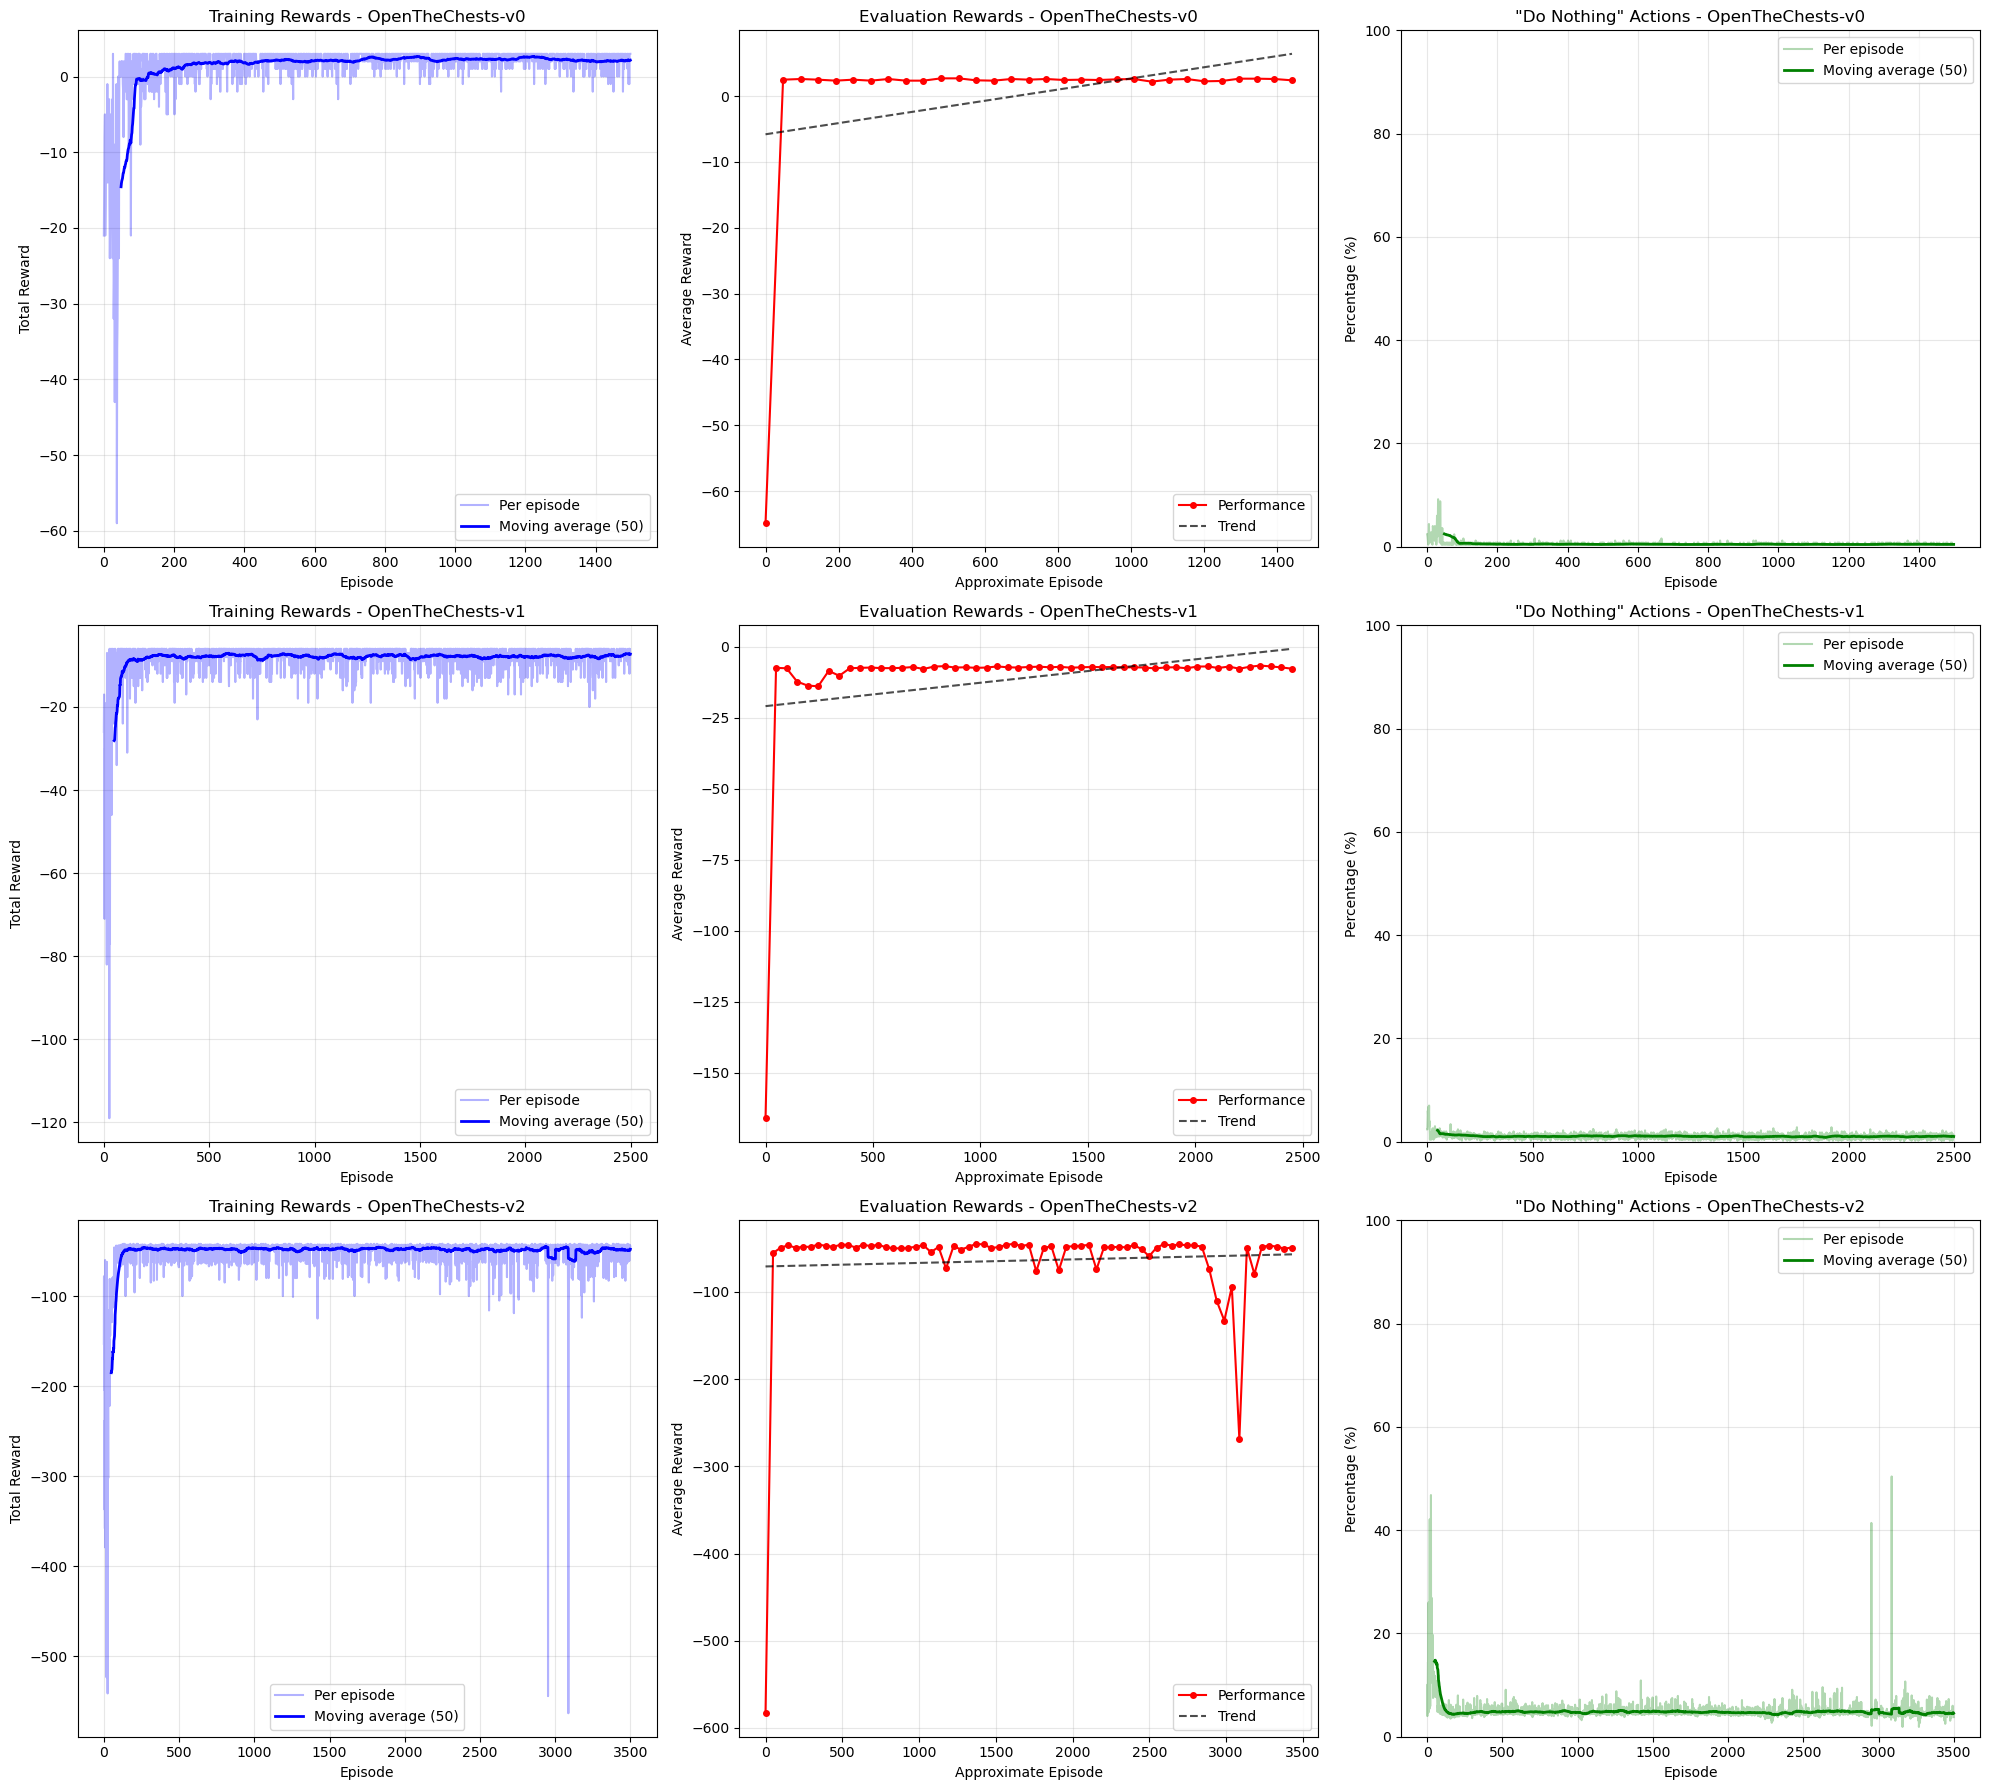


Combined evaluation plot saved as 'combined_evaluation_performance.png'


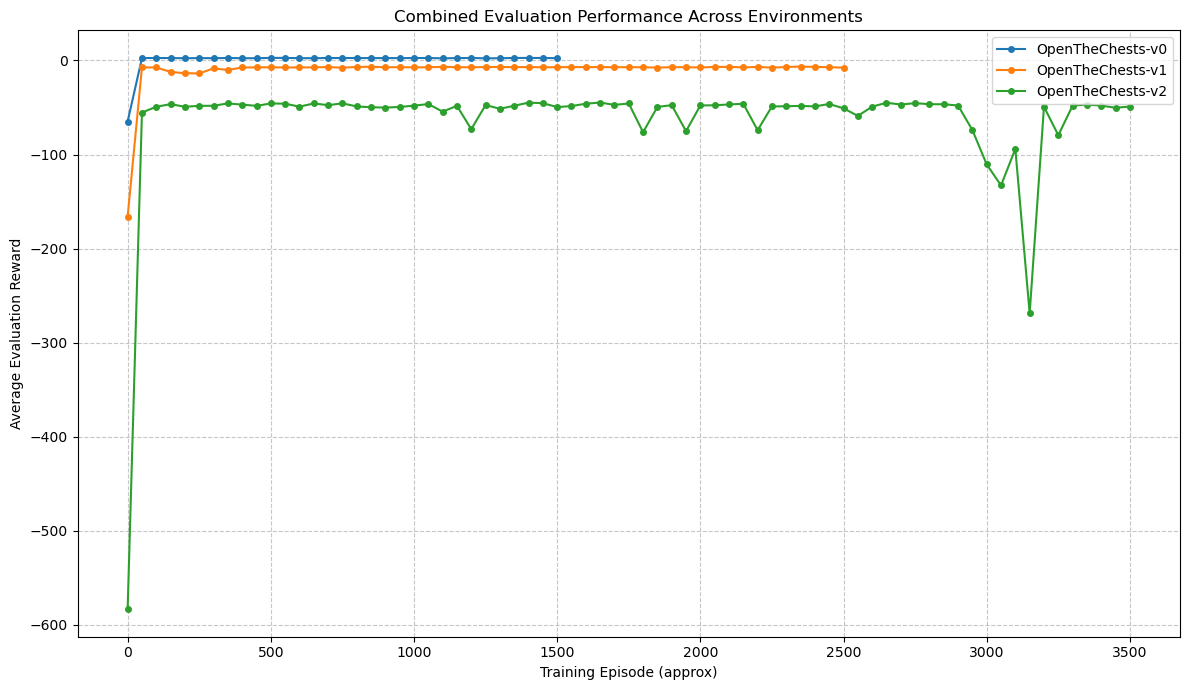


Final Results:
OpenTheChests-v0: Best=2.70, Final=2.40, Avg No-Action=1.2
OpenTheChests-v1: Best=-6.55, Final=-7.65, Avg No-Action=4.8
OpenTheChests-v2: Best=-44.75, Final=-49.00, Avg No-Action=45.5


In [8]:
if __name__ == "__main__":
    # Set random seed for reproducibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Train or load agents for all environment variants
    trained_agents = train_and_evaluate_all_environments(load_if_exists=False)
    
    # Display summary statistics
    print("\nFinal Results:")
    for agent in trained_agents:
        if agent.eval_rewards:
            best_reward = max(agent.eval_rewards)
            final_reward = agent.eval_rewards[-1]
            avg_no_action = np.mean(agent.no_action_counts[-10:])
            print(f"{agent.env_name}: Best={best_reward:.2f}, Final={final_reward:.2f}, Avg No-Action={avg_no_action:.1f}")

### 1.12. Results Analysis

### Analysis of Reinforcement Learning Results for "Open the Chests" Environments

Based on the training logs, I'll analyze the performance of the agent across the three environment variants of increasing complexity.

### OpenTheChests-v0 (Simple Environment)

**Performance Analysis:**
- **Quick Learning**: The agent rapidly improved from initial negative rewards (-21.0) to positive rewards (2.0) by episode 50
- **Stable Convergence**: Performance stabilized early, reaching near-optimal behavior around episode 100
- **High Final Performance**: Achieved a final evaluation score of 2.58 across 50 episodes
- **Best Score**: 2.70 at episode 500
- **Training Stability**: Very stable with consistent performance after initial learning

This matches expectations for v0, where a simple MLP can effectively learn the one-to-one mapping between events and actions. The agent quickly identified the correct action for each event signature.

### OpenTheChests-v1 (Medium Environment)

**Performance Analysis:**
- **Slower Learning**: Started much worse (-26.0 train, -166.0 eval) but improved significantly by episode 50
- **Gradual Improvement**: Performance gradually improved over the 2500 episodes
- **Negative but Stable Rewards**: Best reward was -6.55 at episode 2350
- **Consistent Behavior**: Episodes typically lasted 12-17 steps
- **Final Performance**: -7.36 evaluation reward across 50 episodes

The LSTM-based architecture successfully learned to track short event sequences but couldn't achieve positive rewards. This indicates the increased difficulty of recognizing patterns across 4-event sequences compared to the simple v0 environment.

### OpenTheChests-v2 (Complex Environment)

**Performance Analysis:**
- **Difficult Learning**: Started with very poor performance (-153.0 train, -583.2 eval)
- **Significant Initial Progress**: Major improvements by episode 100 (-45.0 train, -49.25 eval)
- **Training Instability**: Performance fluctuated more than other variants
- **Loss Pattern**: Loss initially decreased but later increased (from ~0.06 to ~0.76), suggesting potential overfitting
- **Long Episodes**: Typically 48-55 steps per episode
- **Best Performance**: -44.75 at episode 1650
- **Final Score**: -49.78 evaluation reward

The complex environment clearly challenged even the sophisticated LSTM+Transformer architecture. The learning curve showed periods of improvement followed by instability, particularly after episode 2500 where performance occasionally degraded significantly (e.g., -110.50 at episode 3000).

### Comparative Analysis

1. **Architecture-Environment Match**:
   - The results confirm that architectural complexity needs to match environmental complexity
   - Simple MLP was sufficient for v0, while v1 and v2 required more sophisticated networks

2. **Learning Efficiency**:
   - Learning speed decreased as environment complexity increased
   - v0: ~50 episodes to reach good performance
   - v1: ~500 episodes 
   - v2: ~1650 episodes

3. **Reward Scaling**:
   - The magnitude of negative rewards corresponds to environment complexity
   - This reflects the increasing difficulty of identifying longer patterns

4. **Training Stability**:
   - Stability decreased with environment complexity
   - v2 showed significant variability in later episodes, suggesting challenges in maintaining consistent performance

5. **Hyperparameter Sensitivity**:
   - Lower learning rates were used for more complex environments
   - v2 required adaptive learning rate scheduling and more sophisticated optimization techniques

These results demonstrate the increasing challenge of pattern recognition with longer temporal dependencies, and highlight how different neural network architectures can be adapted to address these challenges.